In [2]:
import torch
from torch import nn
import torch.quantization
import torch.nn.functional as F
from torchvision.transforms import transforms
from torchvision.models import vgg11, VGG11_Weights, resnet50, ResNet50_Weights, resnet152, ResNet152_Weights

from torchvision.models import wide_resnet101_2, Wide_ResNet101_2_Weights
from torch.utils.data import DataLoader, TensorDataset

import os
import cv2
import time
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
def transform(img_x):
    #normalize image x
    transform = transforms.Compose([
        transforms.ToTensor(),
        #using mean and standard deviation of imagenet dataset
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
        transforms.Resize((221, 221), antialias=True)
    ])
    return transform(img_x)

In [4]:
def compute_similarity_matrix(feature_vectors):
    """
    Compute the similarity matrix for visual loop closure detection.

    Args:
        feature_vectors (np.ndarray): CNN feature vectors of shape (n_images, 500).

    Returns:
        np.ndarray: Similarity matrix of shape (n_images, n_images).
    """
    feature_vectors = feature_vectors.reshape(feature_vectors.shape[0], -1)
    normalized_vectors = feature_vectors / np.linalg.norm(feature_vectors, axis=1, keepdims=True)
    n_images = normalized_vectors.shape[0]
    
    distances = np.zeros((n_images, n_images))
    for i in range(n_images):
        for j in range(n_images):
            distances[i, j] = np.linalg.norm(normalized_vectors[i] - normalized_vectors[j])

    max_distance = np.max(distances)
    similarity_matrix = 1 - (distances / max_distance)

    return similarity_matrix

def pca_whiten(features, reduced_dim = 500):
    
    features = features.to('cuda')
    batch_size, _, feature_dim = features.shape
    features = features.view(batch_size, feature_dim)
    
    features_l2_norm = F.normalize(features, p=2, dim=1)
    features_l2_norm = torch.sub(features_l2_norm, torch.mean(features_l2_norm, dim=1).unsqueeze(1))

    cov_matrix = torch.matmul(features_l2_norm.T, features_l2_norm) 
    U, S, V = torch.linalg.svd(cov_matrix)

    principal_components = U[:, :reduced_dim]
    projected_features = torch.matmul(features_l2_norm, principal_components)
    

#     epsilon=1e-5

#     singular_values = S[:projected_features.shape[1]]
#     whitening_matrix = 1.0 / (torch.sqrt(singular_values) + epsilon)
#     whitened_features = projected_features * whitening_matrix
    
#     return whitened_features
    return projected_features

In [5]:
class QuantizedModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model_fp32 = model
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()
        
    def forward(self, x):
        x = self.quant(x)
        x = self.model_fp32(x)
        x = self.dequant(x)
        return x

In [6]:
class OverFeat(nn.Module):
    def __init__(self):
        super(OverFeat, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=(7,7), stride=2)
        self.maxp1 = nn.MaxPool2d(kernel_size=(3, 3), stride=3)

        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=(7,7), stride=1)
        self.maxp2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=1, padding=1)

        self.conv4 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=1, padding=1)

        self.conv5 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(3,3), stride=1, padding=1)
        
        self.conv6 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1)
        self.maxp6 = nn.MaxPool2d(kernel_size=(3,3), stride=3)

        self.linear1 = nn.Linear(1024 * 5 * 5, 4096)
        self.linear2 = nn.Linear(4096, 4096)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxp1(x)

        x = F.relu(self.conv2(x))
        x = self.maxp2(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.maxp6(x)

        x =torch.flatten(x,1)

        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        return x

In [7]:
#GLOBALS


image_dirs = ['data/data/CityCentre_Images',
              'data/data/NewCollege_Images']
gt_matrix_paths = ['data/data/CityCentreTextFormat.txt',
                   'data/data/NewCollegeTextFormat.txt']

# Focal length:
fc = [ 367.481519978327754 , 366.991059667167065 ]
# Principal point:
cc = [ 328.535778962615268 , 233.779960757465176 ]
# Distortion coefficients:
kc = [ -0.293510277812333,0.065334967950619, -0.000117308680498, 0.000304779905426,0.000000000000000 ]

# Camera matrix
camera_matrix = np.array([
    [fc[0], 0, cc[0]],
    [0, fc[1], cc[1]],
    [0, 0, 1]
], dtype=np.float32)

# Distortion coefficients
dist_coeffs = np.array(kc, dtype=np.float32)


In [8]:
def generate_features(model, device, num_images, image_dir):
    model.to(device)
    model.eval()

    features_list = []
    image_files = sorted(os.listdir(image_dir))
    n=num_images #Number of images in dataset we want show the 

    total_time=0
    for i, row in tqdm(enumerate(image_files[0:n])):
        img1_path = os.path.join(image_dir, row)
        img1 = cv2.imread(img1_path)
        undistorted_img1 = cv2.undistort(img1, camera_matrix, dist_coeffs)
        transformed_img1 = transform(undistorted_img1)
        img1 = transformed_img1.to(device)
        with torch.no_grad():
            start_time = time.time()
            features1 = model(img1.unsqueeze(0))
            end_time = time.time()
            total_time += (end_time - start_time)
        features_list.append(features1.cpu())
    avg_run_time = total_time/n
    return (features_list, avg_run_time)

In [9]:
def binarize_similarity_matrix(matrix, threshold):
    threshold = threshold
    binary_similarity_matrix = (matrix > threshold).astype(int)

    #Do this to match howq the ground was coded
    binary_similarity_matrix = np.tril(binary_similarity_matrix)
    np.fill_diagonal(binary_similarity_matrix, 0)
    return binary_similarity_matrix

1it [00:00,  9.48it/s]

Non-Quantized VGG11 Size (MB): 515.071122
Using device: cpu


1073it [01:07, 15.95it/s]


Average Forward Pass Running time (Non_Quantized VGG11):  0.048713393669092865


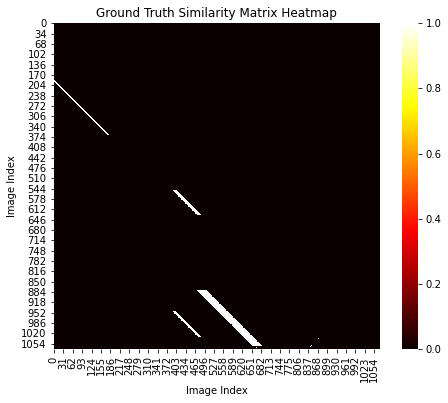

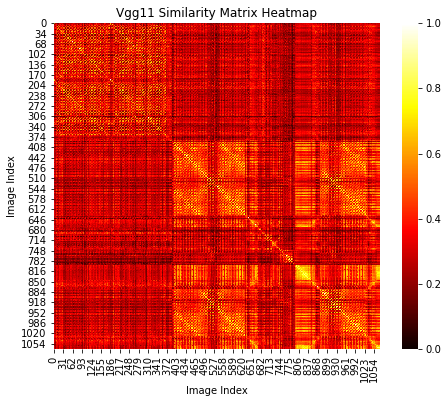

In [42]:
model_vgg11 = vgg11(weights=VGG11_Weights.DEFAULT)
model_vgg11.classifier = torch.nn.Sequential(*list(model_vgg11.classifier.children())[:-3])

torch.save(model_vgg11.state_dict(), "temp.p")
print('Non-Quantized VGG11 Size (MB):', os.path.getsize("temp.p")/1e6)
os.remove('temp.p')

device = torch.device("cpu")
print('Using device:', device)

features_list_vgg11, avg_run_time_vgg11 = generate_features(model=model_vgg11, device=device, num_images=1073, image_dir=image_dirs[1])

print("Average Forward Pass Running time (Non_Quantized VGG11): ", avg_run_time_vgg11)


feature_vectors_vgg11 = np.vstack(features_list_vgg11)

similarity_matrix_vgg11 = compute_similarity_matrix(feature_vectors_vgg11)

similarity_matrix_gt = np.loadtxt(gt_matrix_paths[1], delimiter=',')

plt.figure(figsize=(8,6))
sns.heatmap(similarity_matrix_gt[0:1073,0:1073], annot=False, cmap="hot", square=True)
plt.title("Ground Truth Similarity Matrix Heatmap")
plt.xlabel("Image Index")
plt.ylabel("Image Index")

plt.figure(figsize=(8,6))
sns.heatmap(similarity_matrix_vgg11, annot=False, cmap="hot", square=True)
plt.title("Vgg11 Similarity Matrix Heatmap")
plt.xlabel("Image Index")
plt.ylabel("Image Index")
plt.show()




2it [00:00, 17.30it/s]

Quantized VGG11 Size (MB): 128.812622
Using device: cpu


1073it [00:42, 25.38it/s]


Average Forward Pass Running time (Quantized VGG11):  0.02576285950624265


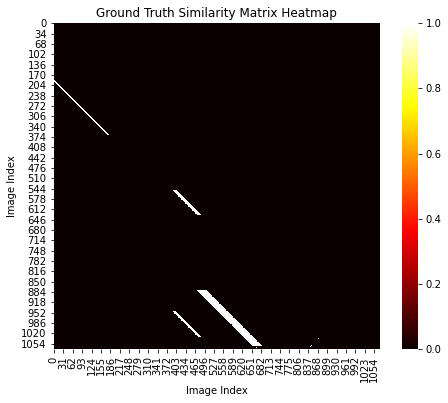

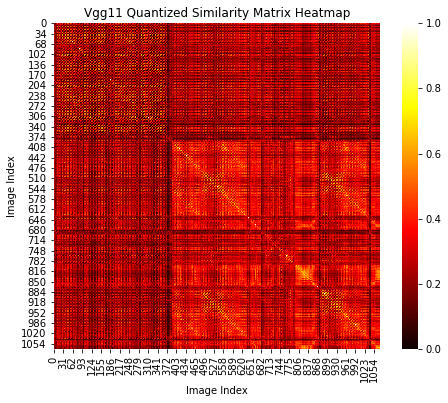

In [43]:
model_vgg11 = vgg11(weights=VGG11_Weights.DEFAULT)
model_vgg11.classifier = torch.nn.Sequential(*list(model_vgg11.classifier.children())[:-3])
model_vgg11_q = QuantizedModel(model_vgg11)
model_vgg11_q.qconfig = torch.quantization.default_qconfig
torch.quantization.prepare(model_vgg11_q, inplace=True)
torch.quantization.convert(model_vgg11_q, inplace=True)

torch.save(model_vgg11_q.state_dict(), "temp.p")
print('Quantized VGG11 Size (MB):', os.path.getsize("temp.p")/1e6)
os.remove('temp.p')


device = torch.device("cpu")
print('Using device:', device)

features_list_vgg11_q, avg_run_time_vgg11_q = generate_features(model=model_vgg11_q, device=device, num_images=1073, image_dir=image_dirs[1])

print("Average Forward Pass Running time (Quantized VGG11): ", avg_run_time_vgg11_q)


feature_vectors_vgg11_q = np.vstack(features_list_vgg11_q)
similarity_matrix_vgg11_q = compute_similarity_matrix(feature_vectors_vgg11_q)



similarity_matrix_gt = np.loadtxt(gt_matrix_paths[1], delimiter=',')

plt.figure(figsize=(8,6))
sns.heatmap(similarity_matrix_gt[0:1073,0:1073], annot=False, cmap="hot", square=True)
plt.title("Ground Truth Similarity Matrix Heatmap")
plt.xlabel("Image Index")
plt.ylabel("Image Index")

plt.figure(figsize=(8,6))
sns.heatmap(similarity_matrix_vgg11_q, annot=False, cmap="hot", square=True)
plt.title("Vgg11 Quantized Similarity Matrix Heatmap")
plt.xlabel("Image Index")
plt.ylabel("Image Index")
plt.show()

Non-Quantized Resnet50 Size (MB): 500.063478
Using device: cuda


1073it [00:24, 43.13it/s]


Average Forward Pass Running time (Non_Quantized resnet50):  0.009567767353893326


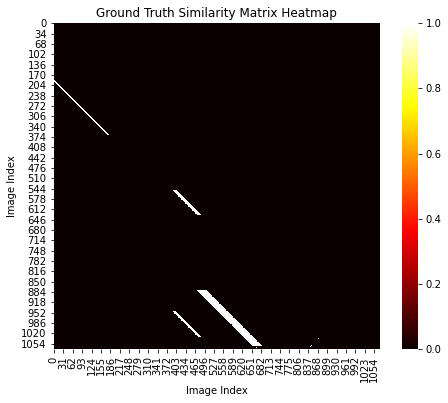

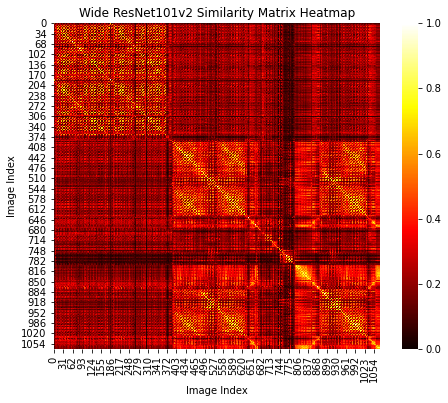

In [47]:
#wide_resnet101_2, Wide_ResNet101_2_Weights
model_resnet50 = wide_resnet101_2(weights=Wide_ResNet101_2_Weights.DEFAULT)
model_resnet50.fc = torch.nn.Identity()


torch.save(model_resnet50.state_dict(), "temp.p")
print('Non-Quantized Resnet50 Size (MB):', os.path.getsize("temp.p")/1e6)
os.remove('temp.p')

device = torch.device("cuda")
print('Using device:', device)

features_list_resnet50, avg_run_time_resnet50 = generate_features(model=model_resnet50, device=device, num_images=1073, image_dir=image_dirs[1])

print("Average Forward Pass Running time (Non_Quantized resnet50): ", avg_run_time_resnet50)


feature_vectors_resnet50 = np.vstack(features_list_resnet50)

similarity_matrix_resnet50 = compute_similarity_matrix(feature_vectors_resnet50)

similarity_matrix_gt = np.loadtxt(gt_matrix_paths[1], delimiter=',')

plt.figure(figsize=(8,6))
sns.heatmap(similarity_matrix_gt[0:1073,0:1073], annot=False, cmap="hot", square=True)
plt.title("Ground Truth Similarity Matrix Heatmap")
plt.xlabel("Image Index")
plt.ylabel("Image Index")

plt.figure(figsize=(8,6))
sns.heatmap(similarity_matrix_resnet50, annot=False, cmap="hot", square=True)
plt.title("Wide ResNet101v2 Similarity Matrix Heatmap")
plt.xlabel("Image Index")
plt.ylabel("Image Index")
plt.show()




<ipython-input-13-33c7448adc19>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoint_8.pth')
1it [00:00,  7.68it/s]

Non-Quantized Overfeat Size (MB): 562.242346
Using device: cpu


1073it [01:20, 13.40it/s]


Average Forward Pass Running time (Non_Quantized OverFeat):  0.054900224255493395


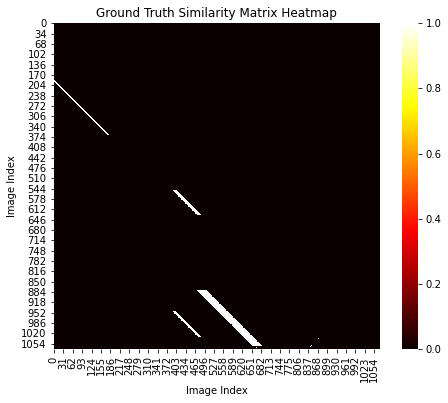

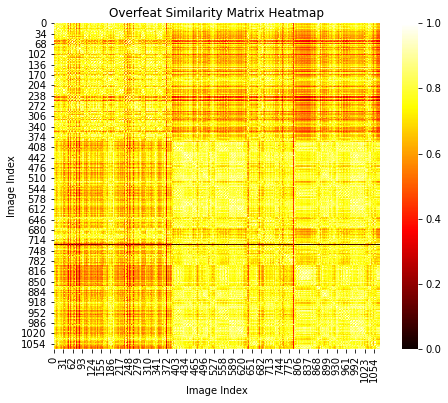

In [13]:
model_overfeat = OverFeat()
checkpoint = torch.load('checkpoint_8.pth')
model_overfeat.load_state_dict(checkpoint['model_state_dict'])

torch.save(model_overfeat.state_dict(), "temp.p")
print('Non-Quantized Overfeat Size (MB):', os.path.getsize("temp.p")/1e6)
os.remove('temp.p')

device = torch.device("cpu")
print('Using device:', device)

features_list_overfeat, avg_run_time_overfeat = generate_features(model=model_overfeat, device=device, num_images=1073, image_dir=image_dirs[1])

print("Average Forward Pass Running time (Non_Quantized OverFeat): ", avg_run_time_overfeat)


feature_vectors_overfeat = np.vstack(features_list_overfeat)
similarity_matrix_overfeat = compute_similarity_matrix(feature_vectors_overfeat)


similarity_matrix_gt = np.loadtxt(gt_matrix_paths[1], delimiter=',')

plt.figure(figsize=(8,6))
sns.heatmap(similarity_matrix_gt[0:1073,0:1073], annot=False, cmap="hot", square=True)
plt.title("Ground Truth Similarity Matrix Heatmap")
plt.xlabel("Image Index")
plt.ylabel("Image Index")

plt.figure(figsize=(8,6))
sns.heatmap(similarity_matrix_overfeat, annot=False, cmap="hot", square=True)
plt.title("Overfeat Similarity Matrix Heatmap")
plt.xlabel("Image Index")
plt.ylabel("Image Index")
plt.show()

<ipython-input-16-c702166b8b14>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoint_8.pth')
0it [00:00, ?it/s]

Quantized Overfeat Size (MB): 140.604606
Using device: cpu


1073it [00:40, 26.74it/s]
<ipython-input-4-f51f58ca3e61>:12: RuntimeWarning: invalid value encountered in true_divide
  normalized_vectors = feature_vectors / np.linalg.norm(feature_vectors, axis=1, keepdims=True)


Average Forward Pass Running time (Quantized OverFeat):  0.023613652889681886


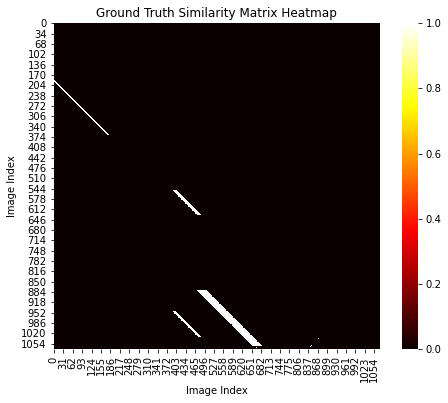

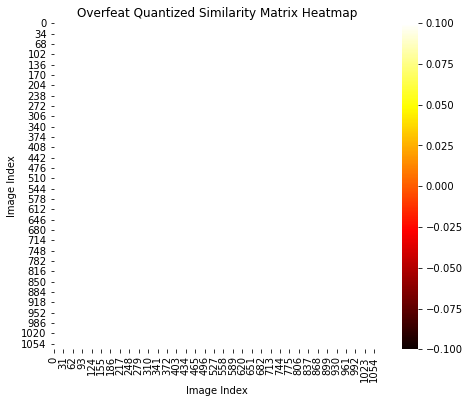

In [16]:
model_overfeat = OverFeat()
checkpoint = torch.load('checkpoint_8.pth')
model_overfeat.load_state_dict(checkpoint['model_state_dict'])

model_overfeat_q = QuantizedModel(model_overfeat)
model_overfeat_q.qconfig = torch.quantization.default_qconfig
torch.quantization.prepare(model_overfeat_q, inplace=True)
torch.quantization.convert(model_overfeat_q, inplace=True)

torch.save(model_overfeat_q.state_dict(), "temp.p")
print('Quantized Overfeat Size (MB):', os.path.getsize("temp.p")/1e6)
os.remove('temp.p')

device = torch.device("cpu")
print('Using device:', device)

features_list_overfeat_q, avg_run_time_overfeat_q = generate_features(model=model_overfeat_q, device=device, num_images=1073, image_dir=image_dirs[1])

print("Average Forward Pass Running time (Quantized OverFeat): ", avg_run_time_overfeat_q)


feature_vectors_overfeat_q = np.vstack(features_list_overfeat_q)
similarity_matrix_overfeat_q = compute_similarity_matrix(feature_vectors_overfeat_q)


similarity_matrix_gt = np.loadtxt(gt_matrix_paths[1], delimiter=',')

plt.figure(figsize=(8,6))
sns.heatmap(similarity_matrix_gt[0:1073,0:1073], annot=False, cmap="hot", square=True)
plt.title("Ground Truth Similarity Matrix Heatmap")
plt.xlabel("Image Index")
plt.ylabel("Image Index")

plt.figure(figsize=(8,6))
sns.heatmap(similarity_matrix_overfeat_q, annot=False, cmap="hot", square=True)
plt.title("Overfeat Quantized Similarity Matrix Heatmap")
plt.xlabel("Image Index")
plt.ylabel("Image Index")
plt.show()

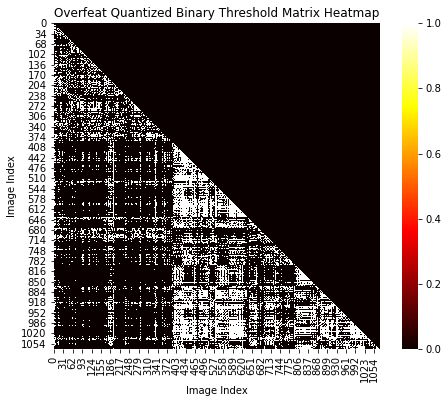

In [20]:
#binary_similarity_matrix_vgg11 = binarize_similarity_matrix(similarity_matrix_vgg11, threshold=0.7)
#binary_similarity_matrix_vgg11_q = binarize_similarity_matrix(similarity_matrix_vgg11_q, threshold=0.60)
#binary_similarity_matrix_resnet50 = binarize_similarity_matrix(similarity_matrix_resnet50, threshold=0.7)

binary_similarity_matrix_overfeat = binarize_similarity_matrix(similarity_matrix_overfeat, threshold=0.8)



# frobenius_diff_vgg11 = np.linalg.norm(binary_similarity_matrix_vgg11 - similarity_matrix_gt[0:1073, 0:1073], ord='fro')
# frobenius_diff_vgg11_q = np.linalg.norm(binary_similarity_matrix_vgg11_q - similarity_matrix_gt[0:1073, 0:1073], ord='fro')
# frobenius_diff_quant = np.linalg.norm(binary_similarity_matrix_vgg11 - binary_similarity_matrix_vgg11_q, ord='fro')


# print(f"Frobenius Norm Difference (VGG11): {frobenius_diff_vgg11}")
# print(f"Frobenius Norm Difference (VGG11 Quantized): {frobenius_diff_vgg11_q}")
# print(f"Frobenius Norm Difference (VGG vs VGG11 Quantized): {frobenius_diff_quant}")




# plt.figure(figsize=(8,6))
# sns.heatmap(binary_similarity_matrix_vgg11, annot=False, cmap="hot", square=True)
# plt.title("Vgg11 Binary Threshold Matrix Heatmap")
# plt.xlabel("Image Index")
# plt.ylabel("Image Index")
# plt.show()


# plt.figure(figsize=(8,6))
# sns.heatmap(binary_similarity_matrix_vgg11_q, annot=False, cmap="hot", square=True)
# plt.title("Vgg11 Quantized Binary Threshold Matrix Heatmap")
# plt.xlabel("Image Index")
# plt.ylabel("Image Index")
# plt.show()


# plt.figure(figsize=(8,6))
# sns.heatmap(binary_similarity_matrix_resnet50, annot=False, cmap="hot", square=True)
# plt.title("Wide Resnet101v2  Binary Threshold Matrix Heatmap")
# plt.xlabel("Image Index")
# plt.ylabel("Image Index")
# plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(binary_similarity_matrix_overfeat, annot=False, cmap="hot", square=True)
plt.title("Overfeat Quantized Binary Threshold Matrix Heatmap")
plt.xlabel("Image Index")
plt.ylabel("Image Index")
plt.show()

In [54]:
def pca_whiten(features, reduced_dim = 500):
    

    features = features.to('cuda')
    batch_size, _, feature_dim = features.shape
    features = features.view(batch_size, feature_dim)
    
    features_l2_norm = F.normalize(features, p=2, dim=1)
    torch.mean(features_l2_norm, dim=1)
    features_l2_norm -= (features_l2_norm - torch.mean(features_l2_norm, dim=1, keepdim=True))

    cov_matrix = torch.matmul(features_l2_norm.T, features_l2_norm) 
    U, S, V = torch.linalg.svd(cov_matrix)

    principal_components = U[:, :reduced_dim]
    projected_features = torch.matmul(features_l2_norm, principal_components)

    epsilon=1e-5

    singular_values = S[:projected_features.shape[1]]
    whitening_matrix = 1.0 / (torch.sqrt(singular_values) + epsilon)
    whitened_features = projected_features * whitening_matrix
    
    return projected_features

  0%|          | 0/34 [00:00<?, ?it/s]

1073
torch.Size([1, 4096])
torch.Size([1073, 1, 4096])


100%|██████████| 34/34 [00:18<00:00,  1.89it/s]


torch.Size([1073, 500])


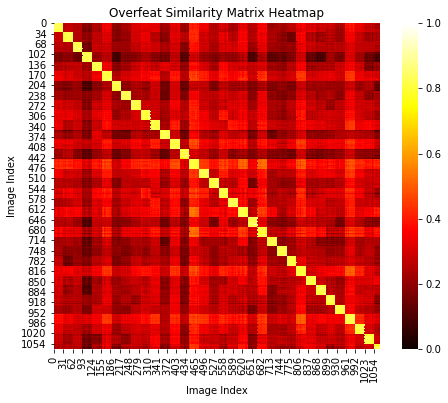

In [55]:
print(len(features_list_vgg11))
print(features_list_vgg11[0].shape)
features_tensor = torch.stack(features_list_vgg11)
print(features_tensor.shape)

feature_dataset = TensorDataset(features_tensor)
dataloader = DataLoader(feature_dataset, batch_size = 32, shuffle = False, num_workers = 8, pin_memory=True)
whiten_batches = []
for batch in tqdm(dataloader):
    batch_features = batch[0]
    batch_whiten_featues = pca_whiten(batch_features, 500)
    whiten_batches.append(batch_whiten_featues)


whiten_features_all = torch.cat(whiten_batches, dim=0)

print(whiten_features_all.shape)

similarity_matrix_whitten = compute_similarity_matrix(whiten_features_all.cpu())


plt.figure(figsize=(8,6))
sns.heatmap(similarity_matrix_whitten, annot=False, cmap="hot", square=True)
plt.title("Overfeat Similarity Matrix Heatmap")
plt.xlabel("Image Index")
plt.ylabel("Image Index")
plt.show()